In [55]:
import matplotlib.pyplot as plt
import jax.numpy as jnp
from jax import random
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive
import arviz as az
import seaborn as sns
from numpyro.diagnostics import hpdi

A slightly modified version of <a>https://james-brennan.github.io/posts/horseshoe/</a>.

<h1> Generate Data </h1>

In [66]:
from sklearn.datasets import make_sparse_coded_signal

y, X, beta = make_sparse_coded_signal(n_samples=1,
                                   n_components=50,
                                   n_features=100,
                                   n_nonzero_coefs=20,
                                   random_state=0)

X = X.T 
print(jnp.equal(y, X@beta)) # assert y = X @ beta

# add some noise to y
y += 0.1 * random.normal(key=random.PRNGKey(1), shape=(len(y),))

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True]


<h2> Define the Model </h2>

Horseshoe prior:
$$ \tau \sim C^+(0, 1)$$
$$ \lambda_i \sim C^+(0, 1)$$
$$ \beta_i \sim N(0, \tau^2 \lambda_i^2) $$
$$ y \sim N(\beta, \sigma^2) $$

where $\beta$ is the average of all $\beta_i$ and $\sigma = 0.1$ in this example.

In [71]:
def horseshoe_linear_model(y=None, X=None, y_sigma=0.1):
    '''
    Parameters:
       array y: dependent variable
       array X: independent variable
       int y_sigma: stdev of y
    '''
    n_predictors = X.shape[1] # 50 predictors (length of beta)
    Tau = numpyro.sample('tau', dist.HalfCauchy(1))
    with numpyro.plate('data', n_predictors): # for i in range(n_predictors):
        Lambda = numpyro.sample('lambda', dist.HalfCauchy(1)) 
        Beta = numpyro.sample('beta', dist.Normal(0, Tau*Lambda))
    mu = jnp.dot(X, Beta) 
    numpyro.sample('y', dist.Normal(mu, y_sigma), obs=y)

<h1> Run MCMC </h1>

In [52]:
mcmc = MCMC(
    NUTS(horseshoe_linear_model),
    num_warmup=500,
    num_samples=1000
)
mcmc.run(random.PRNGKey(5), y=y, X=X)

sample: 100%|█| 1500/1500 [00:01<00:00, 946.43it/s, 127 steps of size 3.82e-02. 


We can inspect our model's learned parameters using `az.plot_trace`. The `compact` argument allows us to plot multiple variables in one plot.

array([[<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>],
       [<Axes: title={'center': 'lambda'}>,
        <Axes: title={'center': 'lambda'}>],
       [<Axes: title={'center': 'tau'}>, <Axes: title={'center': 'tau'}>]],
      dtype=object)

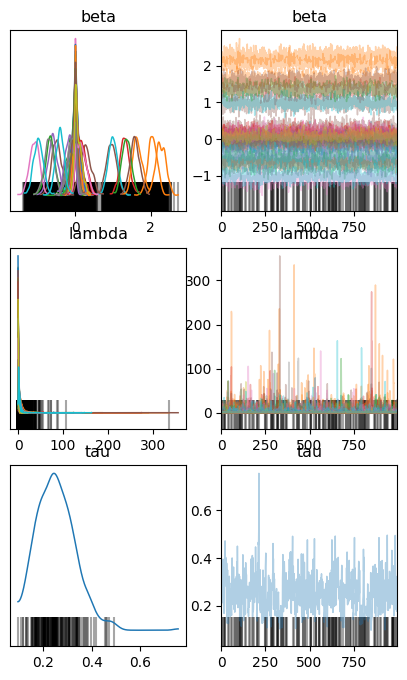

In [38]:
data = az.from_numpyro(mcmc)
az.plot_trace(data, compact=True, figsize=(5,8))

<h1> Results </h1>

In [62]:
posterior_samples = mcmc.get_samples()
print(jnp.max(posterior_samples['beta']))

2.7358081


`posterior_samples` is a dictionary with our sample values of $\beta$, $\tau$, and $\lambda$. For example, since $\beta$ is a length 50 vector, `posterior_samples['beta']` is a $1000 \times 50$ matrix.

In [25]:
beta_mu = jnp.mean(posterior_samples['beta'], axis = 0)
print(beta_mu.shape)

(50,)


We take the mean across all 1000 samples, resulting in a length 50 vector.

Text(0, 0.5, '$\\beta_i$')

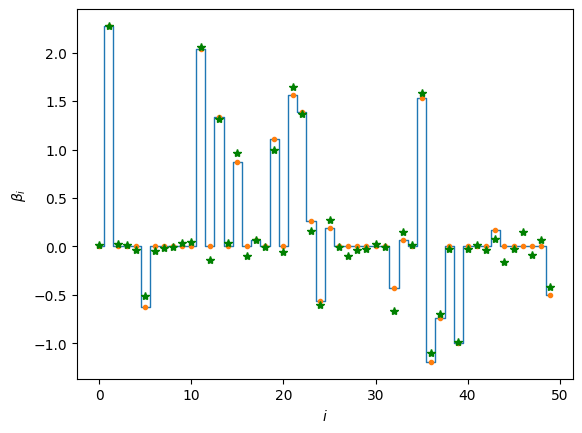

In [64]:
plt.step(range(len(beta)), beta,  where='mid', lw=1) # blue line
plt.plot(range(len(beta)), beta, '.') # actual values
plt.plot(range(len(beta)), beta_mu, 'g*') # predicted values
plt.xlabel(r'$i$')
plt.ylabel(r'$\beta_i$')

In [28]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
   beta[0]      0.01      0.09      0.00     -0.10      0.18    621.57      1.00
   beta[1]      2.27      0.13      2.27      2.07      2.51    768.32      1.00
   beta[2]      0.03      0.08      0.02     -0.09      0.16    539.95      1.00
   beta[3]      0.02      0.09      0.01     -0.12      0.17    489.64      1.01
   beta[4]     -0.03      0.09     -0.02     -0.18      0.12    381.04      1.01
   beta[5]     -0.51      0.13     -0.50     -0.72     -0.29    752.07      1.00
   beta[6]     -0.04      0.09     -0.02     -0.20      0.10    471.00      1.00
   beta[7]     -0.02      0.08     -0.01     -0.16      0.11    575.18      1.00
   beta[8]     -0.01      0.08     -0.00     -0.14      0.13    753.59      1.00
   beta[9]      0.04      0.10      0.02     -0.11      0.21    494.95      1.00
  beta[10]      0.05      0.10      0.03     -0.10      0.21    434.46      1.00
  beta[11]      2.06      0

<h1> Comparison with Linear Model</h1>

Prior: 
$$\beta_i \sim \text{Uniform}(-1000, 1000)$$
$$y \sim N(\beta, \sigma)$$

In [13]:
def linear_model(y=None, X=None, y_sigma=0.1):
    n_predictors = X.shape[1]
    with numpyro.plate('beta plate', n_predictors):
        Beta = numpyro.sample('Beta', dist.Uniform(-1000, 1000))
    mu = jnp.dot(X, Beta)
    numpyro.sample('y', dist.Normal(mu, y_sigma), obs=y)

linear_mcmc = MCMC(
    NUTS(linear_model),
    num_warmup = 500,
    num_samples = 1000)
linear_mcmc.run(random.PRNGKey(3), y=y, X=X)
linear_posterior_samples = linear_mcmc.get_samples()
linear_beta_mu = jnp.mean(linear_posterior_samples['Beta'], axis=0)

sample: 100%|█| 1500/1500 [00:00<00:00, 1698.75it/s, 15 steps of size 1.91e-02. 


array([[<Axes: title={'center': 'Beta'}>,
        <Axes: title={'center': 'Beta'}>]], dtype=object)

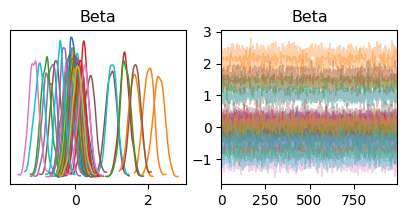

In [37]:
data = az.from_numpyro(linear_mcmc)
az.plot_trace(data, compact=True, figsize=(5,2))

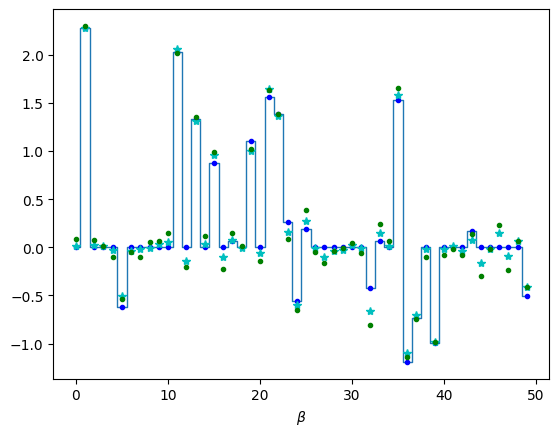

In [30]:
plt.step(range(len(beta)), beta,  where='mid', lw=1) # blue line
plt.plot(range(len(beta)), beta, 'b.') # actual values
plt.plot(range(len(beta)), beta_mu, 'c*') # predicted values
plt.xlabel(r'$\beta$')
plt.plot(range(len(beta)), linear_beta_mu, 'g.')

In [29]:
linear_mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
   Beta[0]      0.09      0.14      0.09     -0.13      0.34    665.31      1.00
   Beta[1]      2.30      0.16      2.30      2.04      2.57    703.24      1.00
   Beta[2]      0.08      0.14      0.07     -0.15      0.31    509.90      1.00
   Beta[3]      0.02      0.14      0.02     -0.21      0.24    888.69      1.00
   Beta[4]     -0.10      0.15     -0.10     -0.32      0.16    793.38      1.00
   Beta[5]     -0.54      0.14     -0.54     -0.77     -0.32    685.79      1.00
   Beta[6]     -0.05      0.13     -0.05     -0.29      0.15    939.81      1.00
   Beta[7]     -0.10      0.13     -0.09     -0.30      0.12    808.53      1.00
   Beta[8]      0.06      0.15      0.06     -0.21      0.29    482.50      1.00
   Beta[9]      0.07      0.14      0.07     -0.16      0.30    789.98      1.00
  Beta[10]      0.15      0.17      0.15     -0.12      0.42    665.23      1.00
  Beta[11]      2.02      0